## Square Wave from Transceiver

In [1]:
import Transceiver_ADRV9009_DataCollection as txvr
import Transceiver_SquareWave_Generation as square_wave
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Sinusoid Params:
Set the Sinusoid params here.  F_in is the desired frequency of the squarewave.  F_actual is a placeholder here.  Used to remind me that the GenerateSinewaves() class tries to access all the adc codes.  So, after creting the ideal waveform, the actual frequency is F_actual.  Make sure to either have F_LO overlap or F_in be within the bandwidth of the ADRV9009 receiver(F_LO -124.5 MHz, F_LO + 124.5MHz).

In [2]:
F_in = 1536e6

#### Data Generation Params:
These params have to do with generating an ideal chirp and putting into the tranceiver design.  TX_sample rate is the sample rate of the tranceiver, 153.6MHz corresponds to the MGT Frequency of the Si570 Clock and 80 - the lane rate.  TX_N_Samples is the number of samples the ideal chirp will consist of - which is constant and based on the hdl design.  The tx_bram_filename is the name of the file that must then be loaded onto the zcu102 and run with load_bram.c, to activate the tranceiver with new data.

prior tx_bram time was ~50us now it should be ~200us

In [3]:
TX_sample_rate = 80*153.6e6
TX_N_samples = 32*1024*80
tx_bram_filename = "tx_bram.txt"

#### Data Collection Params:
These params have to do with collecting data from the ADRV9009.  The RX_sample_rate is fixed at 245.76MHz.  F_LO is the LO frequency and should be set near F_center and within the bandwidth (245.76MHz).  RX_N_sample is the number of samples to collect.

In [4]:
RX_sample_rate = 245.76e6
RX_N_sample = 1024*100
F_LO = 1500e6

#### HDF5 Params:
These params initialize the hdf5 class.  The hdf5_datafile is the name of the file where all the chirp data collected later in this script will be saved.  Collect_HDF5() is initalized by the hdf5_datafile and gets an object used later to access hdf5 methods.  Since running the hdf5 collection can be time consuming I added hdf5_save_en which allows to omit saving chirp data.

In [5]:
hdf5_datafile = 'adrv9009_sinusoid_test.hdf5'
hdf5_save = txvr.Collect_HDF5(hdf5_datafile = hdf5_datafile)
hdf5_save_en = True

### Make a Sinusoid and plot the ideal response:

In [6]:
mysine = square_wave.Square_Wave(F_in = F_in, F_sample = TX_sample_rate, N = TX_N_samples, text_name = tx_bram_filename)

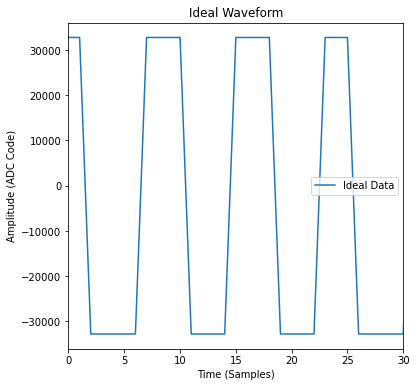

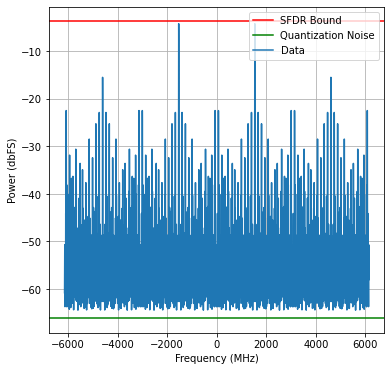

In [7]:
xf_ideal, R_dB_ideal, x_data = mysine.make_waveform(verbose = True)

#### Check number of samples in tx_bram 

In [8]:
df = pd.read_csv("tx_bram.txt", header=None)
df.shape

(65536, 1)

In [9]:
df[0].apply(hex)

0        0x8383838383878783
1                    0x8787
2        0xc787c787c787c787
3                    0xc787
4        0x878387c7878387c7
                ...        
65531                0x8787
65532    0x8783838383878787
65533                0x8787
65534    0xc7c7c7c787878787
65535                0x8787
Name: 0, Length: 65536, dtype: object

#### Save the Ideal Params

In [10]:
df_ideal_sine_params = hdf5_save.make_df_from_object_params(mysine)
if(hdf5_save_en == True):
    hdf5_save.save_df_to_hdf5(df_in = df_ideal_sine_params, hdf5_datafile = hdf5_datafile, title = "Ideal_Chirp_params")

saved dataframe to Ideal_Chirp_params table


In [11]:
df_ideal_sine_params.head()

,F_sample,F_in,N,text_name
0,1.228800e+10,1.536000e+09,2621440,b'tx_bram.txt'


#### Save the Ideal Data

In [12]:
df_ideal = pd.DataFrame(x_data)
if(hdf5_save_en == True):
    ideal_data_array = hdf5_save.complex128_to_complexint(df_in = df_ideal)
    hdf5_save.save_array_data_to_hdf5(nparray_in = ideal_data_array, title = "Ideal_Data")

C:\Users\mmedrano\Desktop\Waveform_Analysis\Transceiver_ADRV9009_DataCollection.py:785: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if(nparray_in == None):


# After this scp tx_bram.txt and put.sh to the zcu102/adrv9009 OS and run put.sh

- scp "tx_bram.txt" into  /home/root on the zcu102
- scp "put.sh" the helper script that loads tx_bram.txt data into the tx_bram memory space into /home/root on the zcu102

<img src="images/scp.png" alt="Drawing" style="width: 800px;">

#### Run the helper script ./put.sh to load tx_bram data into tx_bram memory.  put.sh also generates rx_bram.txt - the data at the rx_bram memory

<img src="images/load_txbram.png" alt="Drawing" style="width: 800px;">

### Configure the ADRV9009 Receiver

This class sets the params in the ADRV9009 receiver.  The rx bandwidth of the ADRV9009 defaults to 245.76 MHz, so make sure that the LO frequency is set near the chirp center frequency in the ideal chirp.  Here I have set them to 700 MHz.

In [14]:
adrv9009_config = txvr.ADRV9009_Config(ip = "ip:192.168.1.21", f_lo = F_LO, rx_gain = 25, rx_buffer_size = RX_N_sample,
                 tx_gain = -14, calibrate_rx_phase_correction_en = 0, calibrate_rx_qec_en = 0, calibrate_tx_qec_en = 0, 
                 calibrate = 1)

#### Check params of ADRV9009 handle
Vars in the ADRV9009 class can be written/read directly like below.  

The python wiki on the ADRV9009 is here: https://analogdevicesinc.github.io/pyadi-iio/devices/adi.adrv9009.html

In [15]:
#adrv9009_config.sdr.trx_lo = F_LO
adrv9009_config.sdr.trx_lo

1500000000

#### Save all the adrv9009_config params to the hdf5 table
If this complains - rerun txvr.ADRV9009_Config()

In [16]:
df_adrv9009_config_params = hdf5_save.make_df_from_object_params(adrv9009_config)
if(hdf5_save_en == True):
    hdf5_save.save_df_to_hdf5(df_in = df_adrv9009_config_params, hdf5_datafile = hdf5_datafile, title = "ADRV9009_Data_Collection_params")

saved dataframe to ADRV9009_Data_Collection_params table


In [17]:
df_adrv9009_config_params.head()

,rx_buffer_size,ip,frequency_hopping_mode,frequency_hopping_mode_en,calibrate_rx_phase_correction_en,calibrate_rx_qec_en,calibrate_tx_qec_en,calibrate,gain_control_mode_chan0,gain_control_mode_chan1,rx_hardwaregain_chan0,rx_hardwaregain_chan1,tx_hardwaregain_chan0,tx_hardwaregain_chan1,rx_rf_bandwidth,tx_rf_bandwidth,rx_sample_rate,tx_sample_rate,trx_lo
0,102400,b'ip:192.168.1.21',1500000000,0,0,0,0,1,b'manual',b'manual',25,30,-14,-10,200000000,225000000,245760000,245760000,1500000000


### Get ADC data

In [18]:
data = adrv9009_config.get_ADC_data_Read()

#### Save the Raw Data to the hdf5 File

In [19]:
df_data_raw = pd.DataFrame(data)
if(hdf5_save_en == True):
    raw_data_array = hdf5_save.complex128_to_complexint(df_in = df_data_raw)
    hdf5_save.save_array_data_to_hdf5(nparray_in = raw_data_array, title = "Raw_Data")

C:\Users\mmedrano\Desktop\Waveform_Analysis\Transceiver_ADRV9009_DataCollection.py:785: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if(nparray_in == None):


#### Plot the Raw Data

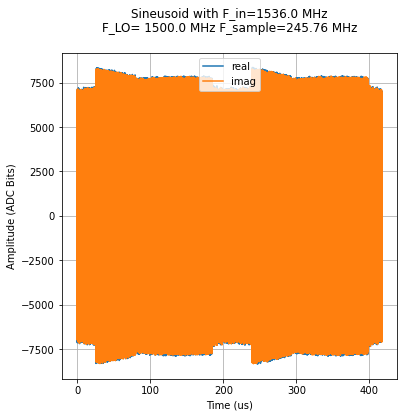

In [20]:
plt.figure(figsize = (6,6))
plt.plot(np.arange(0, len(data))/RX_sample_rate*1e6, np.real(data), label="real")
plt.plot(np.arange(0, len(data))/RX_sample_rate*1e6, np.imag(data), label="imag")
plt.ylabel("Amplitude (ADC Bits)")
plt.xlabel("Time (us)")
plt.legend()
plt.title("Sineusoid with F_in=" + str(F_in/1e6) + " MHz\nF_LO= " + str(F_LO/1e6) + " MHz F_sample=" + str(RX_sample_rate/1e6) + " MHz\n")
plt.grid()
plt.show()

#### Plot the FFT of the Data

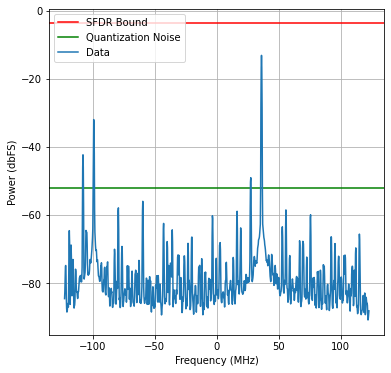

In [21]:
spur_analysis = square_wave.Quantization_Spur_Analysis(F_in = F_in, F_sample = RX_sample_rate, bits = 1)
xf, R_dB, w_cg, w_ig = spur_analysis.getFFT_noise(data = data, N_t = 1024, plot_en = True)

#### Plot data from ADRV9009 and ideal data

In [22]:
offset = -8

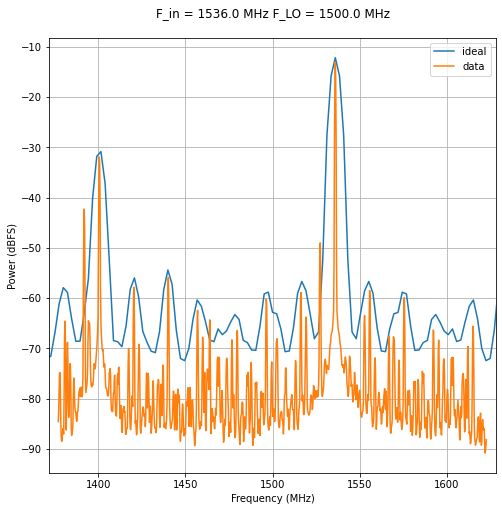

In [23]:
plt.figure(figsize = (8,8))
plt.title("F_in = " + str(F_in/1e6) + " MHz F_LO = " + str(F_LO/1e6) + " MHz\n")
plt.plot(xf_ideal, R_dB_ideal+offset, label="ideal")
plt.plot(F_LO/1e6+xf, R_dB, label="data")
plt.xlim(F_LO/1e6-128, F_LO/1e6+128)
plt.legend()
plt.grid()
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dBFS)")
plt.show()